# Redes Adversárias Generativas (GANs)

Vamos aprender a aplicar as Redes Adversárias Generativas (GANs)? Vamos utilizar a clássica base de dados MNIST. Esse dataset é disponibilizado pelo Keras e consistem em imagens de treinamento e imagens de teste para classificar dígitos escritos a mão que variam entre 0 a 9.

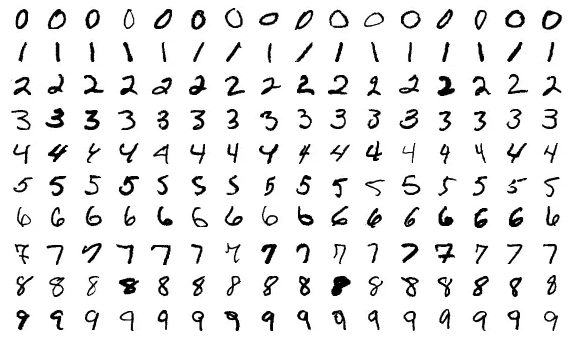

Importando a biblioteca do tensorflow. Tensorflow contém a biblioteca Keras que modela as imagens para redes neurais e também a própria base de dados que vamos utilizar nessa aula: https://keras.io/api/datasets/mnist/

## O que são as redes adversárias gerativas? 🤔

As redes Adversárias Generativas possuem um grande potencial pois **são capazes de gerar novos dados a partir de um conjunto de dados treinados**. Podemos treinar essa rede para criar, por exemplo, novas imagens, músicas, falas, prosas, tratar resoluções de imagens e vídeos e muito mais. Uma das suas utilidades também pode ser criar novas imagens a partir de um conjunto de dados real para criar mais amostras de dados ao treinar uma rede neural convolucional.

Os algoritmos generativos tentam prever os recursos (dados) com um determinado rótulo. Por exemplo, dado que um e-mail é classificado com spam, qual é a probabilidade de palavras que formam esse e-mail spam? Os algoritmos discriminativos se preocupam com a correlação entre x e y, **modelos generativos se preocupam em “como você irá obter x”**.

In [ ]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [ ]:
# Bibliotecas fundamentais para a execução dessa rede
import os
import glob #gerar gif
import imageio #gerar gif
import matplotlib.pyplot as plt # gerar gráficos
import numpy as np # trabalhar com arrays
import PIL # manipular imagens
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import time

from IPython import display

In [ ]:
# Subindo a base de dados
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # definindo o tamaho da imagem (28x28) com 1 canal de cinza
train_images = (train_images - 127.5) / 127.5 # normalizando a imagem para -1, 1

In [ ]:
BUFFER_SIZE = 60000 # tamanho do conjunto de dados
BATCH_SIZE = 256 # quantidade de pixels que varia

In [ ]:
# criando a base de treinamento
# from_tensor_slices: imagens dentro de um tensor
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # conjunto de dados + batch para normalizar os pixels

## Criando a rede GANs

Basicamente as GANs são compostas por duas redes, a geradora e a discriminante. São chamadas de adversárias porque essas duas redes tentam “jogar” uma com a outra o tempo todo. A rede geradora tenta enganar a rede discriminante gerando dados fakes semelhantes aos dados reais.

* O **objetivo da rede discriminate** aqui é reconhecer que os dígitos gerados a mão são o mais próximos possíveis dos verdadeiros números.

* A **rede geradora** tenta criar novas imagens fakes com a esperança de torná-las autênticas também (mesmo sendo falsas).

O funcionamento da rede consiste nas seguintes etapas: O gerador considera números aleatórios e retornam uma imagem (ou seja, cria uma imagem fake); Essa imagem fake gerada pelo gerador é inserida no discriminador ao lado do fluxo de imagens verdadeiras geradas; o discriminador obtém imagens reais e falsas retornando a probabilidade realizando previsões de imagens falsas geradas pela rede generativa.

Vamos criar como próximo passo essas duas redes:

In [ ]:
# criando o nosso modelo gerador de imagens fakes (a partir de uma entrada (ruído) tenta criar uma imagem)

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # entrada de um ruído randomico (a primeira imagem vai ter a profundidade 256 de 7*7)
  model.add(layers.BatchNormalization()) # técnica que normaliza (z-score) os pesos de uma camada para a próxima camada # limita os valores em um máximo e um mínimo (ajuda a ficar com um valor estável)
  model.add(layers.LeakyReLU())          # função de ativação onde os valores negativos sejam transmitidos (atribui um valor pequeno para aproximar o valor à 0)

  model.add(layers.Reshape((7,7,256))) #para deixar no formato de imagem
  assert model.output_shape == (None, 7, 7, 256) # None é o batch size

  #Conv2DTranspose: camada de convolução para aumentar a imagem #padding aplicar bordas de zeros para ajudar a aumentar a imagem
  model.add(layers.Conv2DTranspose(128,(5, 5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5, 5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh')) #imagem final da imagem gerada canal 1
  assert model.output_shape == (None, 28, 28, 1)

  return model

Agora utilizando a função geradora de imagens, vamos ver o que ela pode criar de forma aleatória.

Criando a primeira imagem nunca treinada antes:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


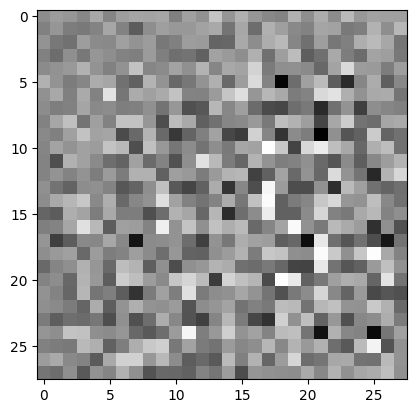

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100]) # ruído
generator_image = generator(noise, training=False) # entrada inicial

plt.imshow(generator_image[0, :, :, 0], cmap='gray')

Agora vamos criar a função do modelo discriminativo:

In [ ]:
# classifica a imagem entre real e fake
# rede convolucional que discrimina imagem real de imagem fake
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image) # valor positivo, imagem real. Valor negativo, imagem fake.
print(decision)

tf.Tensor([[-0.0003852]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


O discriminador acusou um valor POSITIVO para essa imagem gerada de forma aleatória. Ou seja, considerou a imagem real.

(No meu exemplo discriminador acusou um valor NEGATIVO, ou seja, considerou uma imagem fake.)

Criar a rede Gans onde a cada época a imagem vai ser construída. Vamos a princípio configurar a função de custo e para essa solução vamos utilizar a Adam.

Relembrando, o Adam combina elementos do método do momento (momentum) e da média móvel exponencial para **ajustar as taxas de aprendizado de forma adaptativa** para cada parâmetro do modelo.

In [ ]:
# configurando a função de custo (loss function)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # crio uma função loss

Cada modelo precisa ter sua **função de custo** parametrizada:

Para cada saída do generator, o **discriminator avalia se a imagem é fake. A idéia é o discriminator atualizar os pesos baseado no erro gerado para o discriminator considerar essa imagem real** (quanto mais próximo de 1, mais aceitável será pelo discriminator)

O generator tenta enganar o discriminator. Um depende do outro para para a rede funcionar.

**O generator criar cada vez melhor imagens fakes e o discriminator cada vez mais saber avaliar as imagens se são fakes ou reais**.

In [ ]:
# função loss para o discriminador

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # dado real # 1 verdadeiro
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # dado fake # 0 falso
  total_loss = real_loss + fake_loss # faz a comparação
  return total_loss

In [ ]:
# avaliar fake gerado
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output) # dado fake apenas

In [ ]:
# definindo o otimizador da função de custo Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Vamos criar um checkpoint para salvar o aprendizado do modelo. Você vai perceber que esses modelos de deep learning costumam demorar muito no aprendizado e processamento. Ter um checkpoint para salvar o aprendizado é uma boa dica!

In [ ]:
# para salvar o modelo
checkpoint_dir = './training_checkpoints' #diretório para salvar pontos específicos de rede
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

Vamos definir as épocas de processamento:

In [ ]:
EPOCHS = 35
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Vamos criar uma função para acompanharmos a evolução da rede:

In [ ]:
# criando uma função para mostrar a evolução dos passos de treinamento

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Gerando ruído aleatório para a entrada do gerador
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Usando GradientTape para registrar as operações para o cálculo do gradiente
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Gerando imagens usando o gerador
        generated_images = generator(noise, training=True)

        # Calculando as saídas reais e falsas usando o discriminador
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculando as perdas do gerador e do discriminador
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculando os gradientes em relação aos parâmetros do gerador e do discriminador
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicando os gradientes usando otimizadores separados para gerador e discriminador
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Como próximo passo, vamos criar a função responsável por treinar a rede! Nessa função vamos utilizar o checkpoint para salvar o processamento da rede e vamos utilizar a função generate_and_save_images (que será criada logo em seguida) para gerar as imagens processadas pela rede.

In [ ]:
def train(dataset, epochs):
  # Itera sobre o número especificado de épocas
  for epoch in range(epochs):
    start = time.time()  # Marca o início do tempo para esta época

    # Itera sobre os lotes de imagens no conjunto de dados
    for image_batch in dataset:
      train_step(image_batch)  # Chama a função de treinamento definida anteriormente para um lote de imagens

    # Produz imagens para o GIF enquanto treina
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Salva o modelo a cada 15 épocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    # Imprime o tempo decorrido para a época atual
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Gera e salva imagens após a última época
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


In [ ]:
# Função para gerar e salvar imagens usando o modelo treinado

def generate_and_save_images(model, epoch, test_input):
  # Observação: `training` é definido como False.
  # Isso é para que todas as camadas funcionem no modo de inferência (batchnorm).
  predictions = model(test_input, training=False)  # Modo de treinamento False para o gerador criar as imagens

  # Configuração da figura para exibir as imagens geradas
  fig = plt.figure(figsize=(4, 4))

  # Itera sobre as previsões geradas
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # Ajusta a escala e exibe a imagem gerada
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')  # Desliga as coordenadas do eixo

  # Salva a imagem gerada
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()  # Exibe a imagem gerada no momento


E vamos treinar essa rede?

Você vai notar que o tempo de processamento dessa rede neural é muito longo, a minha aqui deu aproximadamente 2 horas 😯

Por isso é importante ter os checkpoints definido!

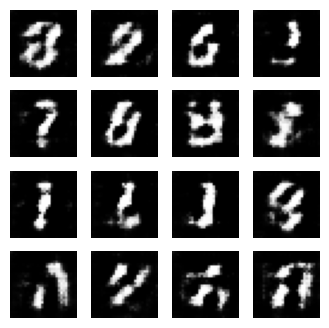

Time for epoch 10 is 772.4996137619019 sec


In [ ]:
train(train_dataset, EPOCHS)